In [5]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import json

In [20]:
# Bottom left of McPherson Library
# (48.463098, -123.309911)

# Bottom left of ECS
# (48.460724, -123.311748)

In [8]:
dat = dict()
with open('../data/bbox.json') as f:
    dat = json.load(f)

im = plt.imread('../images/map.png')

(1238, 2332, 4)
619.0 1166.0


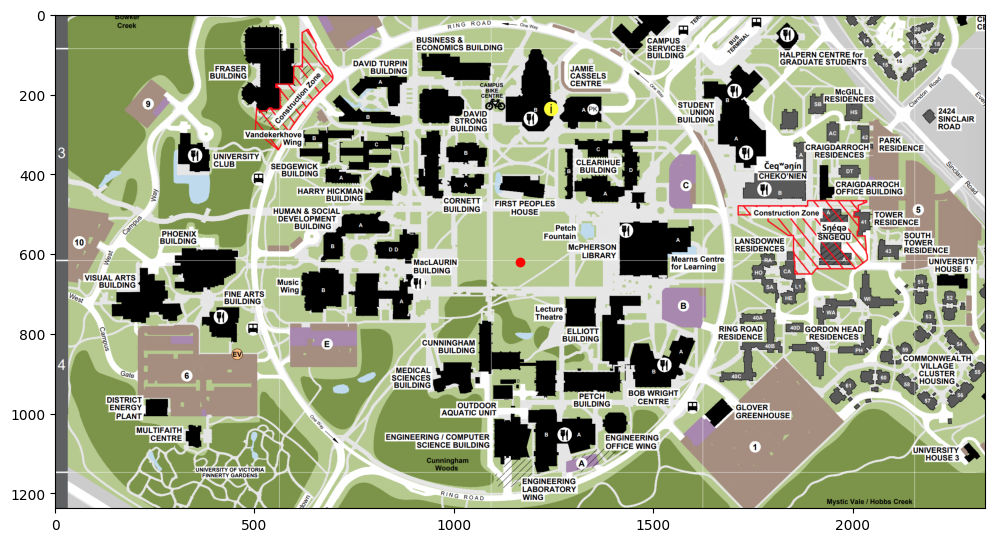

In [9]:
print(im.shape)
print(im.shape[0]/2, im.shape[1]/2)
plt.figure(figsize=(12,12))
plt.imshow(im)

center_long = im.shape[1]/2
center_lat = im.shape[0]/2
plt.scatter(center_long, center_lat, c='r')

In [12]:
# box[0], box[2] = top, bottom
# box[1], box[3] = left, right
boxes_from_center = []
for bldg in dat:
    new_top =  center_lat - bldg[0]
    new_bottom = center_lat - bldg[2] 
    new_left = bldg[1] - center_long
    new_right = bldg[3] - center_long
    boxes_from_center.append([new_top, new_bottom, new_left, new_right])

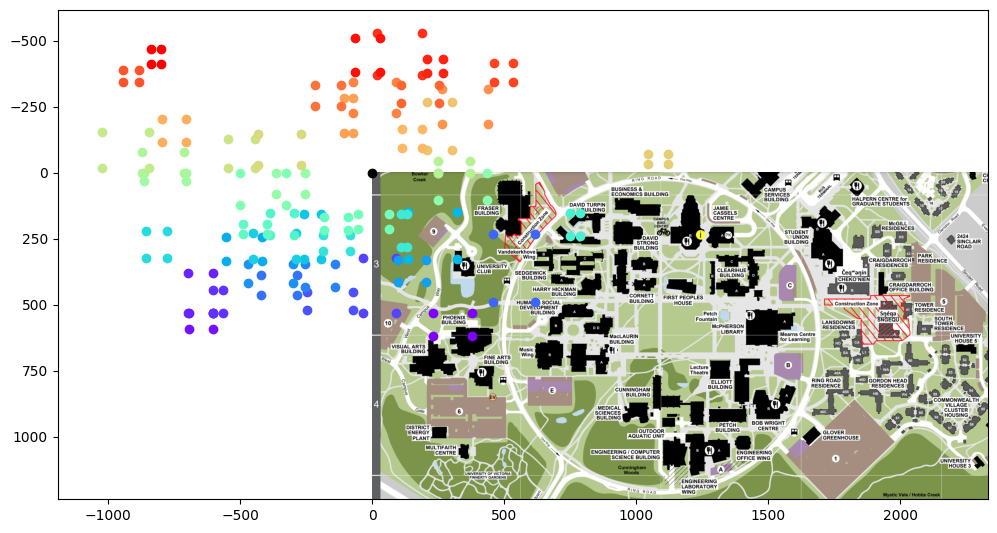

In [15]:
colors = cm.rainbow(np.linspace(0, 1, len(boxes_from_center)))
plt.figure(figsize=(12,12))
plt.imshow(im)
for i, box in enumerate(boxes_from_center):
    plt.scatter(box[2], box[0], color=colors[i])
    plt.scatter(box[3], box[0], color=colors[i])
    plt.scatter(box[2], box[1], color=colors[i])
    plt.scatter(box[3], box[1], color=colors[i])
plt.scatter(0,0, color='black')

In [16]:

theta = -0.10472 # just under 6 degrees
T = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]
])
# T is the inverse of [[cos, -sin], [sin, cos]]

In [18]:
[box for box in boxes_from_center if box[0] == 102.0 or box[0] == -382.0]
# [McPherson, ECS]

[[102.0, 2.0, 249.0, 436.0], [-382.0, -509.0, -65.0, 28.0]]

In [19]:
# MCPHERSON longitude/pixel
lon_diff = -123.311666 - (-123.309911)
pix_diff = 252.13067587
lon_per_pix = lon_diff/pix_diff
print("longitude per pixel:", lon_per_pix)

# ECS latitude/pixel
lat_diff = 48.463197 - 48.460724
pix_diff = -513.00599485
lat_per_pix = lat_diff/pix_diff
print("latitude per pixel:", lat_per_pix)

longitude per pixel: -6.960676220563203e-06
latitude per pixel: -4.820606435067171e-06


In [23]:
def pix_to_latlon(x,y):
    '''
    Takes a pixel coordinate with 0,0 being center of image and returns the latitude and longitude
    '''

    true_north = np.matmul(T, np.array([x, y]))
    lon = -(true_north[0]*-6.960676220563203e-06)-123.311666
    lat = -(true_north[1]*-4.820606435067171e-06)+48.463197

    return lat, lon

In [31]:
latlon_buildings = dict()
for i, bldg in enumerate(boxes_from_center):
    left_top = pix_to_latlon(bldg[2], bldg[0]) # top left
    right_top = pix_to_latlon(bldg[3], bldg[0]) # top right
    left_bottom = pix_to_latlon(bldg[2], bldg[1]) # bottom left
    right_bottom = pix_to_latlon(bldg[3], bldg[1]) # bottom right
    
    avg_lat = (left_top[0] + left_bottom[0])/2
    avg_lon = (left_top[1] + right_top[1])/2

    # I did not bother uploading the annotated data, hence the name building i.
    latlon_buildings[f'building {i}'] = {
        'lat': avg_lat, 
        'lon': avg_lon
        }

In [33]:
with open('../data/buildings.json', 'w') as f:
    json.dump(latlon_buildings, f)

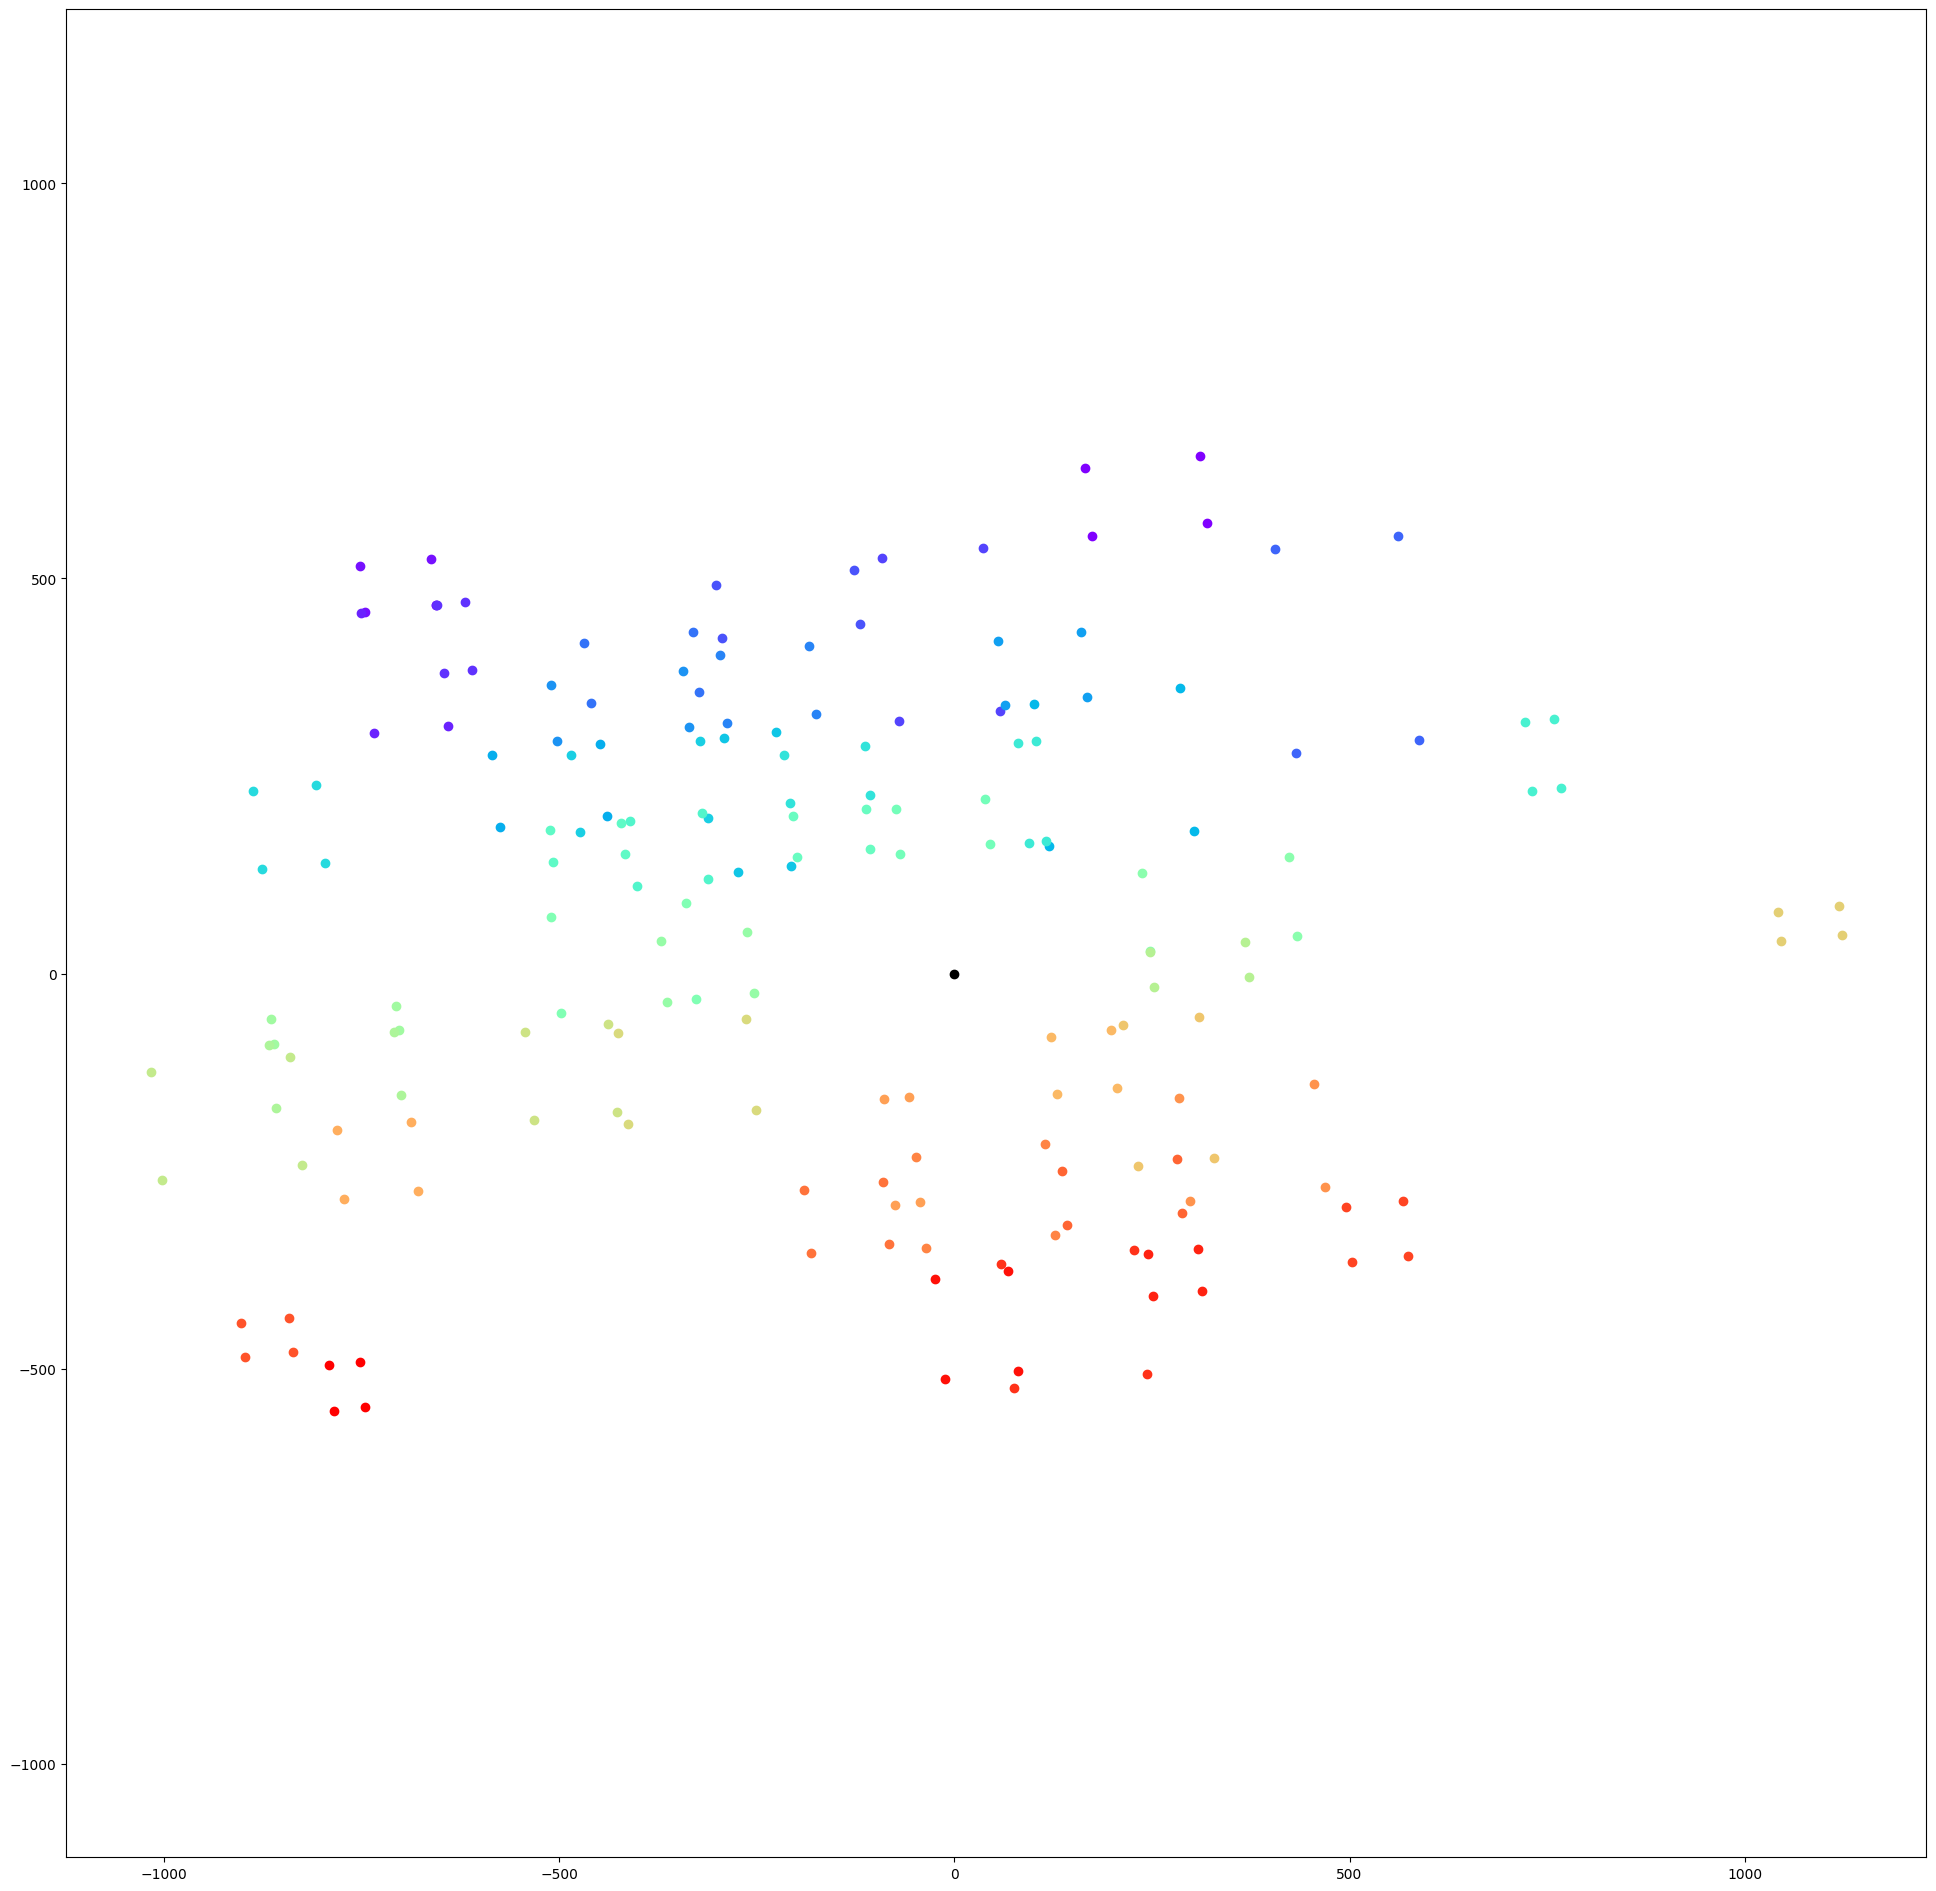

In [34]:
# Visualize the rotated buildings for fun.

# This process does not work if we don't do this.

plt.figure(figsize=(24,24))
plt.axis('equal')
for i, box in enumerate(boxes_from_center):
    rotated_topleft = np.matmul(T, np.array([box[0], box[2]]))
    rotated_topright = np.matmul(T, np.array([box[0], box[3]]))
    rotated_bottomleft = np.matmul(T, np.array([box[1], box[2]]))
    rotated_bottomright = np.matmul(T, np.array([box[1], box[3]]))
    plt.scatter(rotated_topleft[1], rotated_topleft[0], color=colors[i])
    plt.scatter(rotated_topright[1], rotated_topright[0], color=colors[i])
    plt.scatter(rotated_bottomleft[1], rotated_bottomleft[0], color=colors[i])
    plt.scatter(rotated_bottomright[1], rotated_bottomright[0], color=colors[i])
plt.scatter(0,0, color='black')

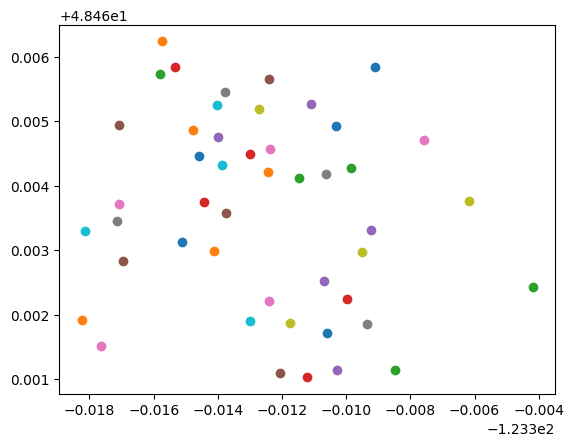

In [42]:
for bldg in latlon_buildings:
    lat,lon = latlon_buildings[bldg].values()
    plt.scatter(lon, lat)

# These are the center latitude and longitude of each building.
# Can't plot against the image because the image is measured in pixels.

# However, the buildings.json file can be used in a leaflet map with JavaScript.